# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.

__Автор__: Никита Владимирович Блохин (NVBlokhin@fa.ru)

Финансовый университет, 2020 г. 

In [79]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import datasets, metrics
import pandas as pd
from sklearn.datasets import make_regression

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [80]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [3]:
class Neuron:
    def __init__(self, in_features: int):
        self.in_features = in_features
        self.weights = torch.randn(self.in_features, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.sum(self.weights * inputs) + self.bias

In [4]:
class SELoss:
    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return (y_pred - y_true) ** 2

In [5]:
torch.manual_seed(0)

In [6]:
neuron = Neuron(X.size(1))
se = SELoss()
lr = 0.1
epochs = 10

In [7]:
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)

        loss = se.forward(y_pred, y_true)
        loss.backward()

        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.bias.grad

        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

In [8]:
tens = neuron.weights
tens, coef

(tensor([44.2134, 43.4610, 91.5638, 21.2008], requires_grad=True),
 array([44.21341306, 43.461014  , 91.56381033, 21.20078475]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [9]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [10]:
class Linear:
    def __init__(self, in_features: int, out_features: int):
        self.in_features = in_features
        self.out_features = out_features
        self.weights = torch.randn(out_features, in_features, requires_grad=True)
        self.biases = torch.randn(out_features, requires_grad=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.matmul(inputs, self.weights.T) + self.biases

In [11]:
class MSELoss:
    def forward(self, y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
        return torch.mean((y_pred - y_true) ** 2)

In [12]:
class ReLU:
    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return torch.maximum(inputs, torch.tensor(0))

In [13]:
torch.manual_seed(0)

In [14]:
fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()
lr = 0.01
epochs = 1000
losses = torch.empty(epochs)

In [15]:
for epoch in range(epochs):
    y_pred = fc2.forward(relu.forward(fc1.forward(X)))

    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    with torch.no_grad():
        fc1.weights -= lr * fc1.weights.grad
        fc1.biases -= lr * fc1.biases.grad
        fc2.weights -= lr * fc2.weights.grad
        fc2.biases -= lr * fc2.biases.grad

    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()

In [16]:
predicts = fc2.forward(relu.forward(fc1.forward(X)))

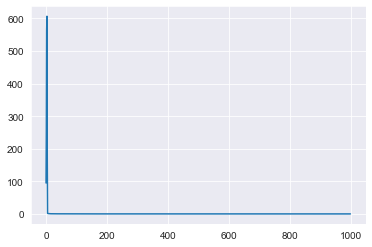

In [17]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

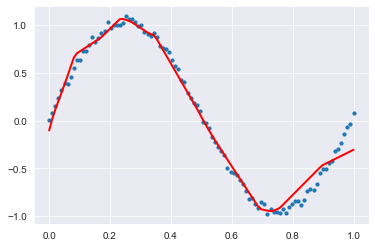

In [18]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

## 2. Алгоритмы оптимизации в `torch.optim`

In [19]:
import torch.optim as optim

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [20]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)

In [21]:
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [22]:
torch.manual_seed(0)

In [23]:
neuron = Neuron(X.size(1))
se = SELoss()
lr = 0.1
optimizer = optim.SGD([neuron.weights, neuron.bias], lr=lr)
epochs = 10

In [24]:
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        optimizer.zero_grad()
        y_pred = neuron.forward(x)
        loss = se.forward(y_pred, y_true)
        loss.backward()
        optimizer.step()

In [25]:
tens = neuron.weights
tens, coef

(tensor([57.4870, 46.6385, 62.3568, 23.2829], requires_grad=True),
 array([57.48701348, 46.63850183, 62.35681511, 23.28290279]))

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [26]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [27]:
torch.manual_seed(0)

In [28]:
fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSELoss()
lr = 0.01
optimizer = optim.Adam([fc1.weights, fc1.biases, fc2.weights, fc2.biases], lr=lr)
epochs = 1000
losses = torch.empty(epochs)

In [29]:
for epoch in range(epochs):
    optimizer.zero_grad()
    y_pred = fc2.forward(relu.forward(fc1.forward(X)))
    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss
    optimizer.step()

In [30]:
predicts = fc2.forward(relu.forward(fc1.forward(X)))

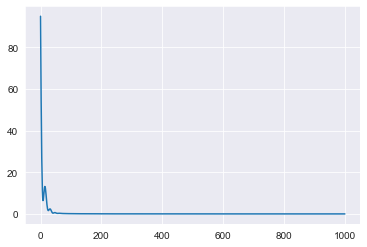

In [31]:
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

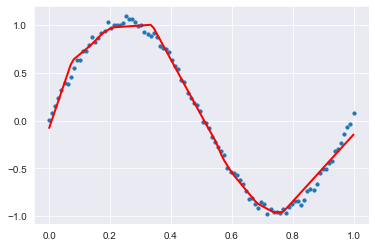

In [32]:
_, ax = plt.subplots(1)
ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

## 3. Построение сетей при помощи `torch.nn`

In [33]:
import torch.nn as nn

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [34]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [35]:
class Net(nn.Module):
    def __init__(self, in_features: int, out_features: int):
        super(Net, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.fc1 = nn.Linear(self.in_features, 100)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(100, self.out_features)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.relu(self.fc1(inputs)))

In [36]:
torch.manual_seed(0)

In [37]:
net = Net(X.size(1), y.size(1))
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [38]:
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

In [39]:
predicts = net(X)

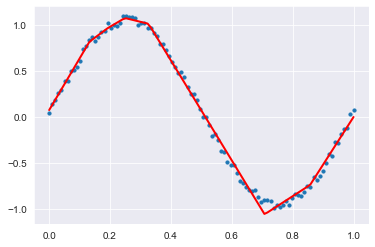

In [40]:
_, ax = plt.subplots(1)
ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [41]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [42]:
torch.manual_seed(0)

In [43]:
in_features = X.size(1)
out_features = y.size(1)

In [44]:
net = nn.Sequential(
    nn.Linear(in_features, 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, out_features),
)

In [45]:
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [46]:
for epoch in range(1000):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

In [47]:
predicts = net(X)

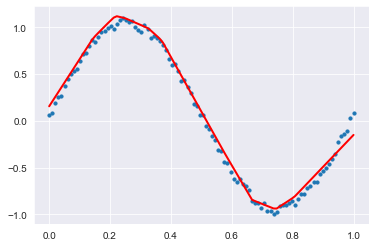

In [48]:
_, ax = plt.subplots(1)
ax.scatter(X, y, s=10)
ax.plot(X, predicts.detach(), c='r', lw=2);

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [49]:
dataset = datasets.load_breast_cancer()

In [50]:
X = torch.from_numpy(dataset.data).to(torch.float32)
y = torch.from_numpy(dataset.target).to(torch.float32).view(-1, 1)

In [51]:
torch.manual_seed(0)

In [52]:
net = nn.Sequential(
    nn.Linear(X.size(1), 50),
    nn.ReLU(),
    nn.Linear(50, y.size(1)),
    nn.Sigmoid(),
)

In [53]:
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [54]:
epochs = 1000

In [55]:
for epoch in range(epochs + 1):
    optimizer.zero_grad()
    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    if epoch % 200 == 0:
        accuracy = metrics.accuracy_score(y, y_pred.round().detach().numpy())
        print(f"Epoch [{epoch:4}/{epochs}]{' ' * 6}loss = {loss:.5f}, accuracy = {accuracy:.5f}")

Epoch [   0/1000]      loss = 10.10273, accuracy = 0.37258
Epoch [ 200/1000]      loss = 0.17000, accuracy = 0.92970
Epoch [ 400/1000]      loss = 0.12417, accuracy = 0.95079
Epoch [ 600/1000]      loss = 0.09693, accuracy = 0.95782
Epoch [ 800/1000]      loss = 0.08035, accuracy = 0.96134
Epoch [1000/1000]      loss = 0.07003, accuracy = 0.97012


## 4. Datasets and dataloaders

In [56]:
from torch.utils.data import Dataset, DataLoader

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [57]:
xytensors = tuple[torch.Tensor, torch.Tensor]
class SinDataset(Dataset):
    def __init__(self):
        self.data = torch.linspace(0, 1, 100).view(-1, 1)
        self.target = torch.sin(2 * np.pi * self.data) + 0.1 * torch.rand(self.data.size())
        
    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx) -> xytensors:
        return self.data[idx], self.target[idx]

In [58]:
sin_dataset = SinDataset()
sin_dataloader = DataLoader(sin_dataset, batch_size=10)

In [59]:
x, y = sin_dataset.data, sin_dataset.target

In [60]:
net = nn.Sequential(
    nn.Linear(x.size(1), 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, y.size(1)),
)

In [61]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [62]:
steps = len(sin_dataloader)
epochs = 500

In [63]:
for epoch in range(epochs + 1):
    for i, (x_, y_) in enumerate(sin_dataloader):
        optimizer.zero_grad()
        y_pred = net(x_)
        loss = criterion(y_pred, y_)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0 and i % 5 == 0:
            print(f"Epoch [{epoch:3}/{epochs}], step [{i:2}/{steps}]"
                  f"{' ' * 6}loss = {loss:.5f}, batch_size = {x_.size(0)}")

Epoch [  0/500], step [ 0/10]      loss = 0.16219, batch_size = 10
Epoch [  0/500], step [ 5/10]      loss = 0.68401, batch_size = 10
Epoch [100/500], step [ 0/10]      loss = 0.02070, batch_size = 10
Epoch [100/500], step [ 5/10]      loss = 0.17524, batch_size = 10
Epoch [200/500], step [ 0/10]      loss = 0.01118, batch_size = 10
Epoch [200/500], step [ 5/10]      loss = 0.01712, batch_size = 10
Epoch [300/500], step [ 0/10]      loss = 0.01117, batch_size = 10
Epoch [300/500], step [ 5/10]      loss = 0.01166, batch_size = 10
Epoch [400/500], step [ 0/10]      loss = 0.01308, batch_size = 10
Epoch [400/500], step [ 5/10]      loss = 0.01136, batch_size = 10
Epoch [500/500], step [ 0/10]      loss = 0.01096, batch_size = 10
Epoch [500/500], step [ 5/10]      loss = 0.00877, batch_size = 10


In [64]:
predicts = net(x)

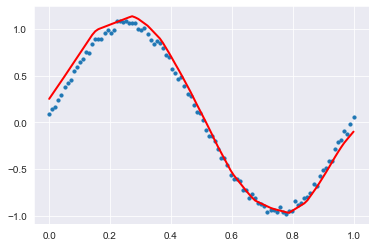

In [65]:
_, ax = plt.subplots(1)
ax.scatter(x, y, s=10)
ax.plot(x, predicts.detach(), c='r', lw=2);

4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [66]:
class DiamondsDataset(Dataset):
    features: torch.Tensor
    labels: torch.Tensor

    def __init__(self, data: pd.DataFrame):
        data = data.select_dtypes(np.number)
        features = data[data.columns.drop("price")]
        labels = data[["price"]]

        self.features = torch.from_numpy(features.to_numpy(dtype=np.float32))
        self.labels = torch.from_numpy(labels.to_numpy(dtype=np.float32))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx) -> xytensors:
        return self.features[idx], self.labels[idx]

In [67]:
import seaborn as sns
diamonds_data = sns.load_dataset("diamonds", data_home="data/")
dataset = DiamondsDataset(diamonds_data)
dataset.features.size(), dataset.labels.size()

(torch.Size([53940, 6]), torch.Size([53940, 1]))

In [68]:
#4.2.2
from torch.utils.data import Dataset, random_split, Subset
train_dataset: Subset
test_dataset: Subset

In [69]:
train_size = round(0.8 * len(dataset))
train_dataset, test_dataset = random_split(dataset, lengths=(train_size, len(dataset) - train_size))

In [70]:
#4.2.3
net = nn.Sequential(
    nn.Linear(dataset.features.size(1), 32),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(32, 96),
    nn.Dropout(0.5),
    nn.ReLU(),
    nn.Linear(96, 32),
    nn.Dropout(0.25),
    nn.ReLU(),
    nn.Linear(32, dataset.labels.size(1)),
    nn.ReLU(),
)

In [71]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [72]:
net.train() 
train_loader = DataLoader(train_dataset, batch_size=256)
steps = len(train_loader)
epochs = 50
losses = torch.empty(epochs + 1)

In [73]:
for epoch in range(epochs + 1):
    total_loss = 0
    for i, (x_, y_) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = net(x_)
        loss = criterion(y_pred, y_)
        loss.backward()
        optimizer.step()
        total_loss += loss
        
        if epoch % 10 == 0 and i % 40 == 0:
            print(f"Epoch [{epoch:4}/{epochs}], step [{i:3}/{steps}]"
                  f"{' ' * 6}loss = {loss:.4f}, R2 = {metrics.r2_score(y_, y_pred.detach().numpy()):.4f}")

Epoch [   0/50], step [  0/169]      loss = 34302164.0000, R2 = -1.0451
Epoch [   0/50], step [ 40/169]      loss = 23906998.0000, R2 = -0.8552
Epoch [   0/50], step [ 80/169]      loss = 18768398.0000, R2 = -0.2886
Epoch [   0/50], step [120/169]      loss = 18868960.0000, R2 = -0.0531
Epoch [   0/50], step [160/169]      loss = 15403959.0000, R2 = -0.0055
Epoch [  10/50], step [  0/169]      loss = 3371349.7500, R2 = 0.7990
Epoch [  10/50], step [ 40/169]      loss = 2635488.0000, R2 = 0.7955
Epoch [  10/50], step [ 80/169]      loss = 2107428.2500, R2 = 0.8553
Epoch [  10/50], step [120/169]      loss = 11200106.0000, R2 = 0.3749
Epoch [  10/50], step [160/169]      loss = 3159187.5000, R2 = 0.7938
Epoch [  20/50], step [  0/169]      loss = 3234383.5000, R2 = 0.8072
Epoch [  20/50], step [ 40/169]      loss = 2291109.0000, R2 = 0.8222
Epoch [  20/50], step [ 80/169]      loss = 2619618.5000, R2 = 0.8201
Epoch [  20/50], step [120/169]      loss = 6233256.5000, R2 = 0.6521
Epoch [  

In [74]:
losses[epoch] = total_loss / steps

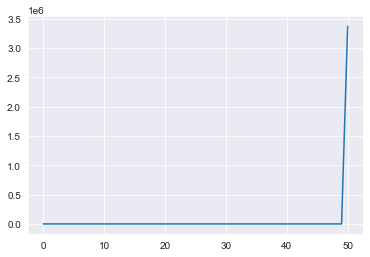

In [75]:
#4.2.4
plt.plot(torch.arange(losses.size(0)), losses.detach().numpy());

In [76]:
net.eval()  # отключает Dropout'ы

(X_train, y_train), (X_test, y_test) = train_dataset[:], test_dataset[:]
print(f"R2 (train): {metrics.r2_score(y_train, net(X_train).detach().numpy())}")
print(f"R2 (test): {metrics.r2_score(y_test, net(X_test).detach().numpy())}")

R2 (train): 0.8587321872955893
R2 (test): 0.8593790734979534


4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [77]:
import typing as t
xytyping = tuple[t.Any, t.Any]

In [78]:
class DiamondsDataset(Dataset):
    features: np.ndarray
    labels: np.ndarray

    def __init__(self, data: pd.DataFrame, transform: t.Callable[[xytyping], xytyping] | None = None):
        self.features = data[data.columns.drop("price")].to_numpy()
        self.labels = data[["price"]].to_numpy()
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx) -> xytyping:
        sample = self.features[idx], self.labels[idx]
        if self.transform:
            return self.transform(sample)
        return sample

TypeError: unsupported operand type(s) for |: '_CallableGenericAlias' and 'NoneType'

In [ ]:
xynumpy = tuple[np.ndarray, np.ndarray]

In [ ]:
class DropColsTransform:

    def __init__(self, drop: list[int]):
        self.drop = drop

    def __call__(self, sample: xynumpy) -> xynumpy:
        features, labels = sample
        return np.delete(features, self.drop, axis=len(features.shape) - 1), labels

In [ ]:
class ToTensorTransform:
  def __call__(self, sample):
    x, y = sample
    return x, y

In [ ]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset(data, transforms.compose([drop, to_tensor]))